<a href="https://colab.research.google.com/github/brianju0218/MLE_S25_Project_Brian_Ju/blob/main/Path_2_5_Damage%26Location_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Set data directory (for Google Colab, mount Google Drive)
from google.colab import drive
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/Colab Notebooks/MLE Project/300.0kHz_2.zip" -d "/content/drive/MyDrive/Colab Notebooks/MLE Project"

Mounted at /content/drive
Archive:  /content/drive/MyDrive/Colab Notebooks/MLE Project/300.0kHz_2.zip
  inflating: /content/drive/MyDrive/Colab Notebooks/MLE Project/300.0kHz_2/2_300.0kHz_A_0g_avg.csv  
  inflating: /content/drive/MyDrive/Colab Notebooks/MLE Project/300.0kHz_2/2_300.0kHz_A_0g_run_0.csv  
  inflating: /content/drive/MyDrive/Colab Notebooks/MLE Project/300.0kHz_2/2_300.0kHz_A_0g_run_1.csv  
  inflating: /content/drive/MyDrive/Colab Notebooks/MLE Project/300.0kHz_2/2_300.0kHz_A_0g_run_10.csv  
  inflating: /content/drive/MyDrive/Colab Notebooks/MLE Project/300.0kHz_2/2_300.0kHz_A_0g_run_11.csv  
  inflating: /content/drive/MyDrive/Colab Notebooks/MLE Project/300.0kHz_2/2_300.0kHz_A_0g_run_12.csv  
  inflating: /content/drive/MyDrive/Colab Notebooks/MLE Project/300.0kHz_2/2_300.0kHz_A_0g_run_13.csv  
  inflating: /content/drive/MyDrive/Colab Notebooks/MLE Project/300.0kHz_2/2_300.0kHz_A_0g_run_14.csv  
  inflating: /content/drive/MyDrive/Colab Notebooks/MLE Project/300.0kH

In [ ]:
import os
import pandas as pd
import numpy as np
import glob
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from scipy.signal import detrend

def load_data(directory, locations=['A', 'B', 'C'], frequency='300.0kHz', runs=None, time_limit=100e-6):
    """Loads time-series data for CNN training with both location and damage classification."""
    data = []
    labels_damage = []
    labels_location = []

    for location in locations:
        file_pattern = os.path.join(directory, f"*_{frequency}_{location}_*_run_*.csv")
        files = glob.glob(file_pattern)
        print(f"Using file pattern: {file_pattern}")
        print(f"Found {len(files)} files matching criteria.")

        for file in files:
            match = re.search(r'_(\d+)g_run_(\d+)', file)
            if match:
                damage = int(match.group(1))  # Extract damage level
                run_num = int(match.group(2))

                if (runs is None) or (run_num < runs):
                    df = pd.read_csv(file)

                    if 's5' not in df.columns or 'Time [s]' not in df.columns:
                        print(f"Skipping file {file} due to missing columns.")
                        continue

                    df_filtered = df[df['Time [s]'] <= time_limit]
                    s5_values = df_filtered['s5'].values
                    s5_values = detrend(s5_values)

                    if len(s5_values) > 0:
                        data.append(s5_values)
                        labels_damage.append(damage)
                        labels_location.append(location)

    # Pad sequences
    max_length = max(len(seq) for seq in data)
    data = pad_sequences(data, maxlen=max_length, padding='post', dtype='float32')

    print(f"Loaded {len(data)} valid sequences.")
    return np.array(data), np.array(labels_damage), np.array(labels_location)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Set data directory (for Google Colab, mount Google Drive)
from google.colab import drive
drive.mount('/content/drive')
data_dir = "/content/drive/MyDrive/Colab Notebooks/MLE Project/300.0kHz_2"

# Load data
X, y_damage, y_location = load_data(data_dir, locations=['A', 'B', 'C'], runs=None)

# Standardize
X = (X - np.mean(X)) / np.std(X)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Encode labels
damage_bins = [0, 20, 40, 60, 80, 100]
y_damage = np.digitize(y_damage, bins=damage_bins) - 1  # 0-5
y_damage_cat = to_categorical(y_damage, num_classes=6)

loc_encoder = LabelEncoder()
y_location_enc = loc_encoder.fit_transform(y_location)  # 0-2
y_location_cat = to_categorical(y_location_enc, num_classes=3)

Mounted at /content/drive
Using file pattern: /content/drive/MyDrive/Colab Notebooks/MLE Project/300.0kHz_2/*_300.0kHz_A_*_run_*.csv
Found 600 files matching criteria.
Using file pattern: /content/drive/MyDrive/Colab Notebooks/MLE Project/300.0kHz_2/*_300.0kHz_B_*_run_*.csv
Found 600 files matching criteria.
Using file pattern: /content/drive/MyDrive/Colab Notebooks/MLE Project/300.0kHz_2/*_300.0kHz_C_*_run_*.csv
Found 600 files matching criteria.
Loaded 1800 valid sequences.


In [ ]:
print(y_damage_cat.shape)
print(y_location_cat.shape)

(1800, 6)
(1800, 3)


In [ ]:
# Create combined labels like 'A_20g', 'B_0g', etc.
combined_labels = np.array([
    "Healthy" if dmg == 0 else f"{loc}_{damage_bins[dmg]}"
    for loc, dmg in zip(y_location, y_damage)
])
# Your desired label order
ordered_labels = ['Healthy',
                  'A_20', 'A_40', 'A_60', 'A_80', 'A_100',
                  'B_20', 'B_40', 'B_60', 'B_80', 'B_100',
                  'C_20', 'C_40', 'C_60', 'C_80', 'C_100']

# Create encoder and fit to desired order
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(ordered_labels)  # Manually set class order
y_combined_encoded = label_encoder.transform(combined_labels)
y_combined_cat = to_categorical(y_combined_encoded)
print("Combined class labels:", np.unique(combined_labels))
print("Encoded values:", np.unique(y_combined_encoded))

Combined class labels: ['A_100' 'A_20' 'A_40' 'A_60' 'A_80' 'B_100' 'B_20' 'B_40' 'B_60' 'B_80'
 'C_100' 'C_20' 'C_40' 'C_60' 'C_80' 'Healthy']
Encoded values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [ ]:
# One-hot encode the integer labels for softmax output
y_categorical = to_categorical(y_combined_encoded, num_classes=len(ordered_labels))

print(f"Encoded labels shape: {y_categorical.shape}")
print(f"Classes: {label_encoder.classes_}")

Encoded labels shape: (1800, 16)
Classes: ['Healthy' 'A_20' 'A_40' 'A_60' 'A_80' 'A_100' 'B_20' 'B_40' 'B_60' 'B_80'
 'B_100' 'C_20' 'C_40' 'C_60' 'C_80' 'C_100']


/usr/local/lib/python3.11/dist-packages/matplotlib/collections.py:1008: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


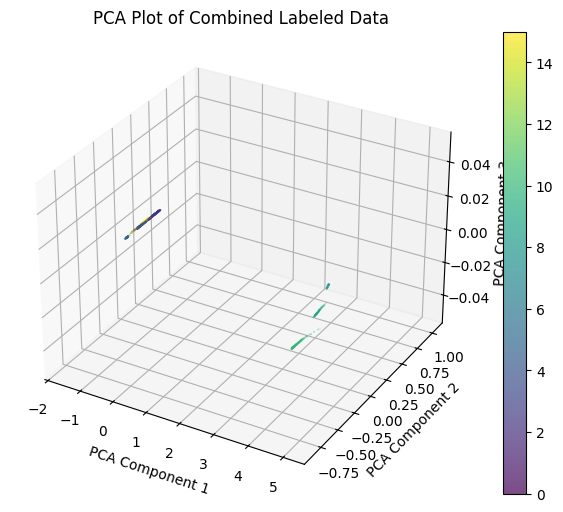

In [ ]:
# pca plot
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
pca = PCA(n_components=3)
X_flat = X.reshape(X.shape[0], -1)  # Flatten time-series data
X_pca = pca.fit_transform(X_flat)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y_combined_encoded, cmap='viridis', alpha=0.7)

# Add colorbar and labels
plt.colorbar(scatter)
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.title('PCA Plot of Combined Labeled Data')
plt.show()

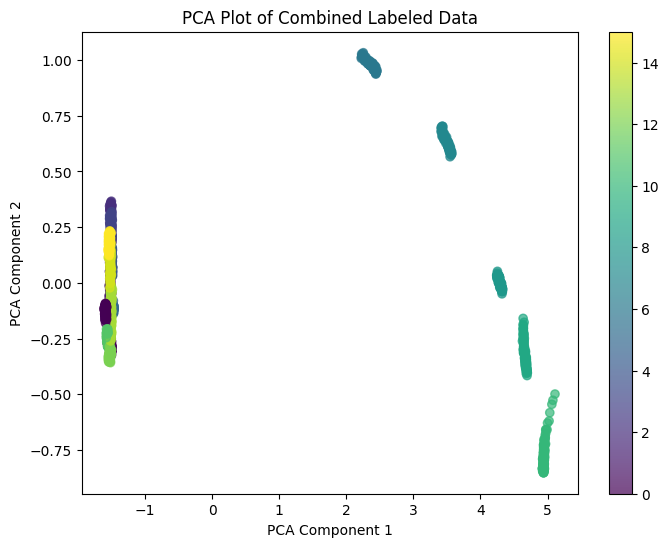

In [ ]:
# pca plot
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
X_flat = X.reshape(X.shape[0], -1)  # Flatten time-series data
X_pca = pca.fit_transform(X_flat)

fig = plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_combined_encoded, cmap='viridis', alpha=0.7)

# Add colorbar and labels
plt.colorbar(scatter)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Plot of Combined Labeled Data')
plt.show()

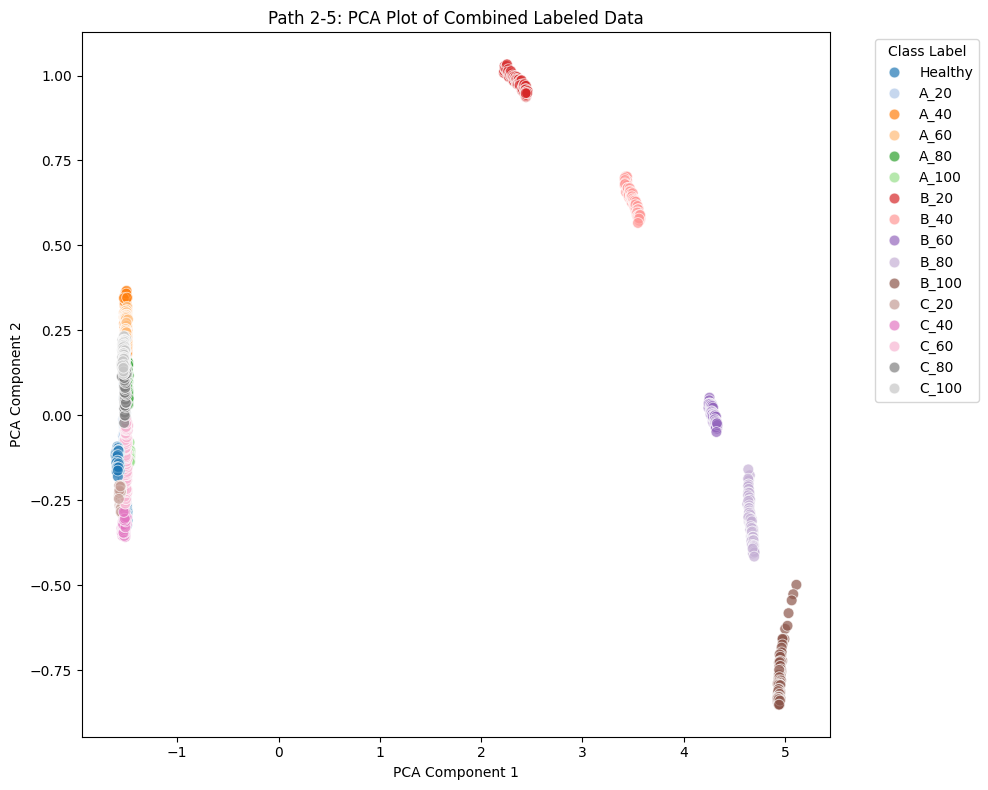

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd

# Flatten time-series data
X_flat = X.reshape(X.shape[0], -1)

# Perform PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_flat)

# Create DataFrame for plotting
df_pca = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'PCA3': X_pca[:, 2],
    'Label': combined_labels # y should contain labels like 'A_0', 'C_5', etc.
})

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='Label', palette='tab20', s=60, alpha=0.7)

plt.title('Path 2-5: PCA Plot of Combined Labeled Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Class Label")
plt.tight_layout()
plt.show()

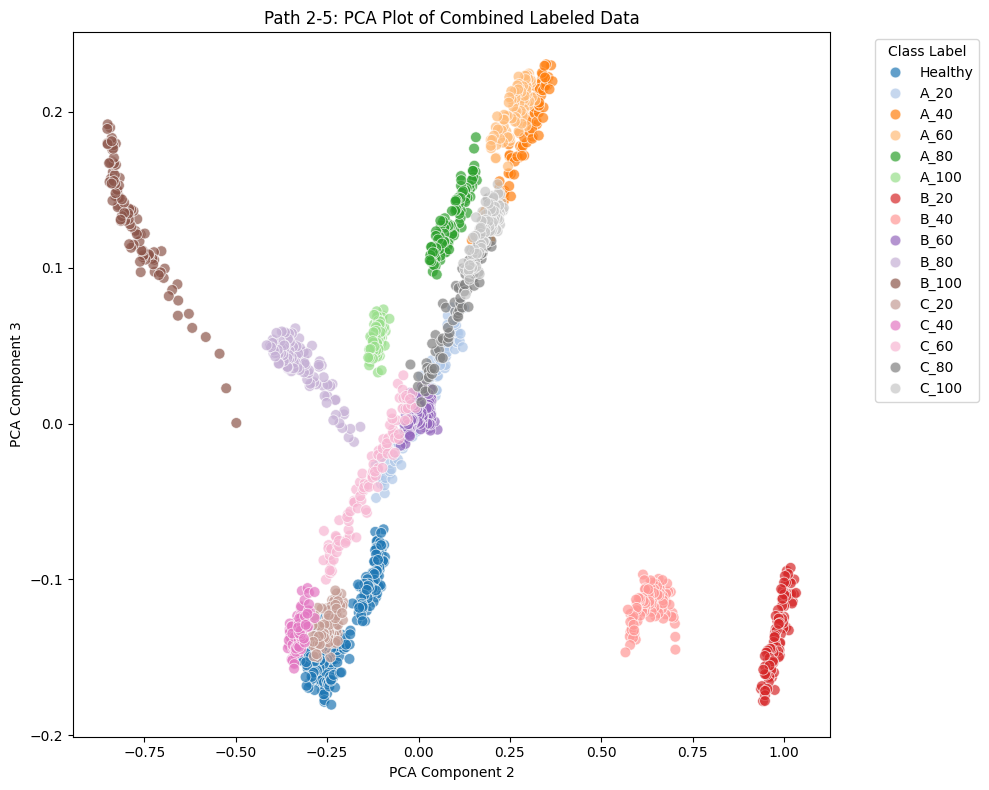

In [ ]:
# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_pca, x='PCA2', y='PCA3', hue='Label', palette='tab20', s=60, alpha=0.7)

plt.title('Path 2-5: PCA Plot of Combined Labeled Data')
plt.xlabel('PCA Component 2')
plt.ylabel('PCA Component 3')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Class Label")
plt.tight_layout()
plt.show()

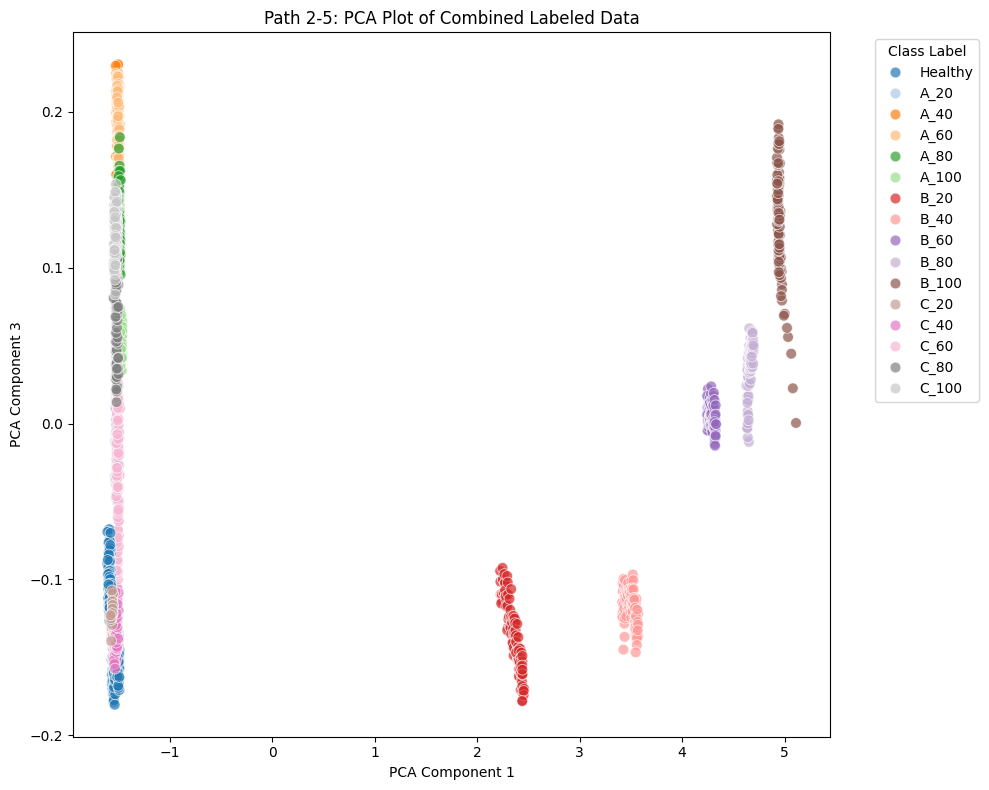

In [ ]:
# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_pca, x='PCA1', y='PCA3', hue='Label', palette='tab20', s=60, alpha=0.7)

plt.title('Path 2-5: PCA Plot of Combined Labeled Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 3')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Class Label")
plt.tight_layout()
plt.show()

In [ ]:
print('principal components: ', X_pca)

principal components:  [[-1.5582391  -0.2430546  -0.1580445 ]
 [-1.5457838  -0.24847306 -0.15146436]
 [-1.5663666  -0.22568066 -0.15150465]
 ...
 [-1.5705751  -0.22063953 -0.13957392]
 [-1.5600177  -0.20914304 -0.12166735]
 [-1.575996   -0.24554744 -0.12311609]]


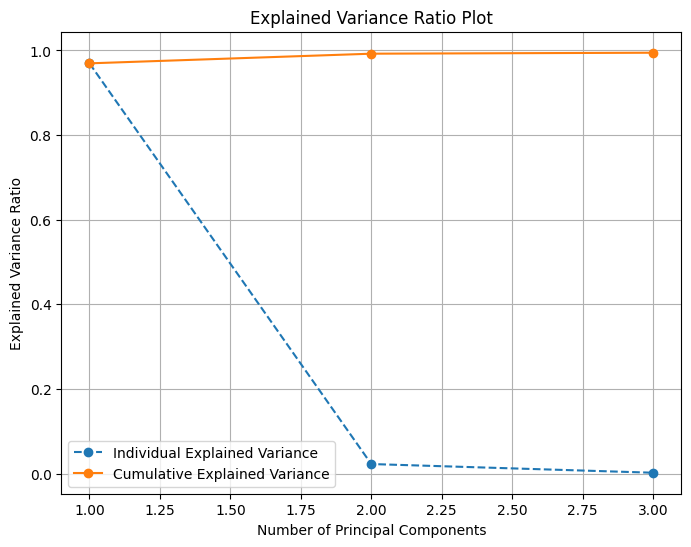

In [ ]:
# explained variance ratio plot
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--', label='Individual Explained Variance')
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', label='Cumulative Explained Variance')
plt.xlabel("Number of Principal Components")
plt.ylabel("Explained Variance Ratio")
plt.title("Explained Variance Ratio Plot")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(X_pca.shape)
print(y_categorical.shape)

(1800, 3)
(1800, 16)


In [ ]:
from sklearn.model_selection import train_test_split

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_categorical, test_size=0.2, random_state=42)
print(f'training data size: ', X_train.shape)
print(f'training data labels size: ', y_train.shape)
print(f'testing data size: ', X_test.shape)
print(f'testing data labels size: ', y_test.shape)

training data size:  (1440, 3)
training data labels size:  (1440, 16)
testing data size:  (360, 3)
testing data labels size:  (360, 16)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import random
import os

# Set seed for NumPy, Python, and TensorFlow
seed_value = 42  # You can pick any fixed number
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Ensure TensorFlow runs in a deterministic manner
os.environ['TF_DETERMINISTIC_OPS'] = '1'

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_pca.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(16, activation='softmax')  # for 16 labels
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,864 (11.19 KB)

 Trainable params: 2,864 (11.19 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=400,  # Adjust based on performance
    batch_size=64,  # Common choice, can be tuned
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.0908 - loss: 2.7771 - val_accuracy: 0.1111 - val_loss: 2.6298
Epoch 2/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1626 - loss: 2.5706 - val_accuracy: 0.2528 - val_loss: 2.4607
Epoch 3/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2640 - loss: 2.3703 - val_accuracy: 0.3056 - val_loss: 2.2743
Epoch 4/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2938 - loss: 2.1892 - val_accuracy: 0.3056 - val_loss: 2.1304
Epoch 5/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3192 - loss: 2.0554 - val_accuracy: 0.3111 - val_loss: 2.0276
Epoch 6/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3179 - loss: 1.9762 - val_accuracy: 0.3056 - val_loss: 1.9438
Epoch 7/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3379 - loss: 1.8919 - val_accuracy: 0.3556 - val_loss: 1.8619
Epoch 8/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3674 - loss: 1.8100 - val_accuracy: 0.4444 - 

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8973 - loss: 0.2301 
Test Accuracy: 0.9000


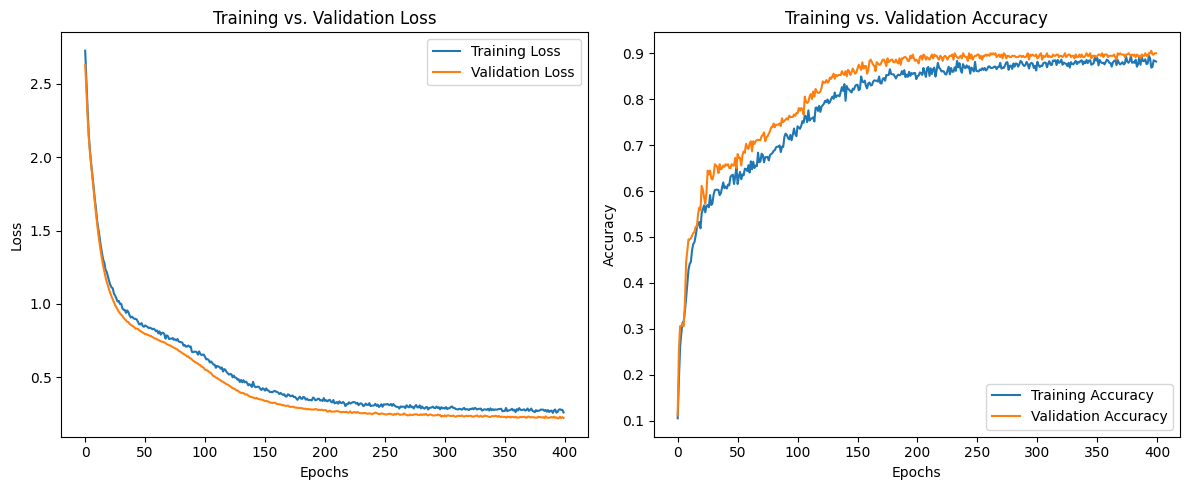

In [ ]:
import matplotlib.pyplot as plt

# Extract training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot Training & Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Predict on test data
y_pred = model.predict(X_test)

# Convert one-hot encoded labels back to class indices
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
              precision    recall  f1-score   support

       A_100       0.96      1.00      0.98        25
        A_20       0.71      0.80      0.75        15
        A_40       0.84      0.76      0.80        21
        A_60       0.96      0.88      0.92        26
        A_80       1.00      1.00      1.00        23
       B_100       1.00      1.00      1.00        17
        B_20       1.00      1.00      1.00        18
        B_40       1.00      1.00      1.00        19
        B_60       1.00      1.00      1.00        18
        B_80       1.00      1.00      1.00        18
       C_100       0.58      0.83      0.68        18
        C_20       0.89      0.73      0.80        22
        C_40       1.00      1.00      1.00        24
        C_60       0.89      0.89      0.89        19
        C_80       0.64      0.43      0.51        21
     Healthy       0.90      0.96      0.93        56

    accuracy                           0

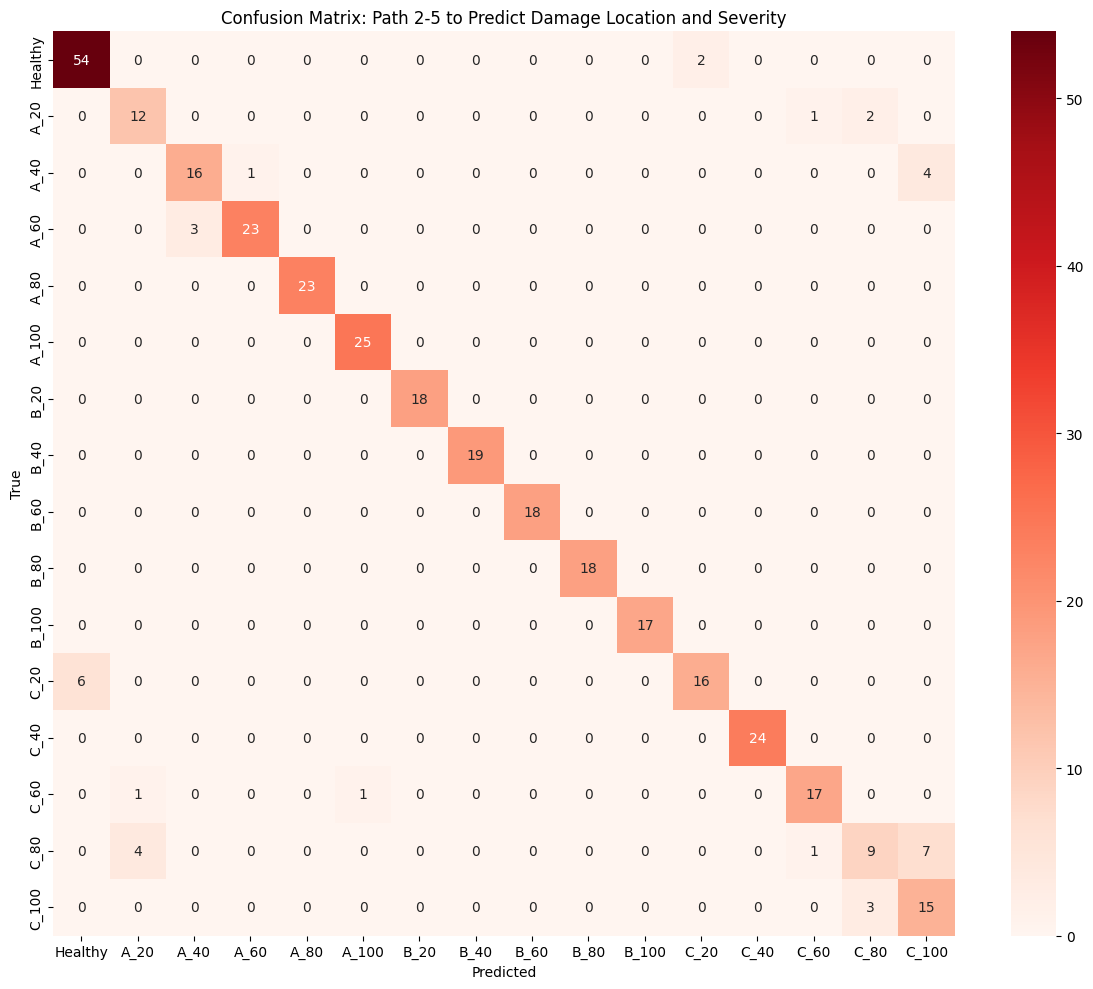

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# Predict
y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Decode labels
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_true_labels = label_encoder.inverse_transform(y_true)

# Classification Report
print(classification_report(y_true_labels, y_pred_labels))

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=label_encoder.transform(ordered_labels))

# Plot with correct label names
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, xticklabels=ordered_labels, yticklabels=ordered_labels, cmap='Reds')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix: Path 2-5 to Predict Damage Location and Severity")
plt.tight_layout()
plt.show()

# Hyperparameter Tuning

In [ ]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import set_random_seed
import keras_tuner as kt

# Reproducibility settings
RANDOM_SEED = 42
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
set_random_seed(RANDOM_SEED)

# Define model building function for tuning
def build_pca_nn_model(hp):
    model = Sequential()
    model.add(Dense(
        hp.Choice('dense_1', [32, 64, 128]),
        activation='relu',
        input_shape=(X_pca.shape[1],)
    ))
    model.add(Dropout(hp.Choice('dropout', [0.2, 0.3, 0.5])))
    model.add(Dense(
        hp.Choice('dense_2', [16, 32, 64]),
        activation='relu'
    ))
    model.add(Dense(16, activation='softmax'))  # for 16 class labels

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
tuner = kt.RandomSearch(
    build_pca_nn_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='pca_nn_tuning',
    project_name='pca_to_nn'
)

tuner.search(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, verbose=1)

Trial 10 Complete [00h 00m 35s]
val_accuracy: 0.8645833134651184

Best val_accuracy So Far: 0.875
Total elapsed time: 00h 06m 17s


In [ ]:
# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]

# Rebuild the model from scratch using the best hyperparameters
best_model = tuner.hypermodel.build(best_hp)
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,808 (38.31 KB)

 Trainable params: 9,808 (38.31 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print(f'best hyperparameters', best_hp.values)

best hyperparameters {'dense_1': 128, 'dropout': 0.3, 'dense_2': 64, 'learning_rate': 0.01}


In [ ]:
# Compile and retrain the new model from epoch 0
history = best_model.fit(X_train, y_train, epochs=400, batch_size=64, validation_split=0.2, verbose=1)

Epoch 1/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.2183 - loss: 2.3329 - val_accuracy: 0.4514 - val_loss: 1.7321
Epoch 2/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4066 - loss: 1.6178 - val_accuracy: 0.5590 - val_loss: 1.2274
Epoch 3/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5128 - loss: 1.2200 - val_accuracy: 0.5764 - val_loss: 1.0465
Epoch 4/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5375 - loss: 1.0719 - val_accuracy: 0.5660 - val_loss: 0.9666
Epoch 5/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5755 - loss: 0.9879 - val_accuracy: 0.5590 - val_loss: 0.9142
Epoch 6/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5982 - loss: 0.9037 - val_accuracy: 0.5729 - val_loss: 0.8757
Epoch 7/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6097 - loss: 0.8467 - val_accuracy: 0.6111 - val_loss: 0.8491
Epoch 8/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6260 - loss: 0.8404 - val_accuracy: 0.6736 - 

In [ ]:
# Evaluate on training data
train_loss, train_acc = best_model.evaluate(X_train, y_train, verbose=0)
print(f"Training Accuracy: {train_acc:.4f}")

# Evaluate on testing data
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

Training Accuracy: 0.9014
Test Accuracy: 0.8778


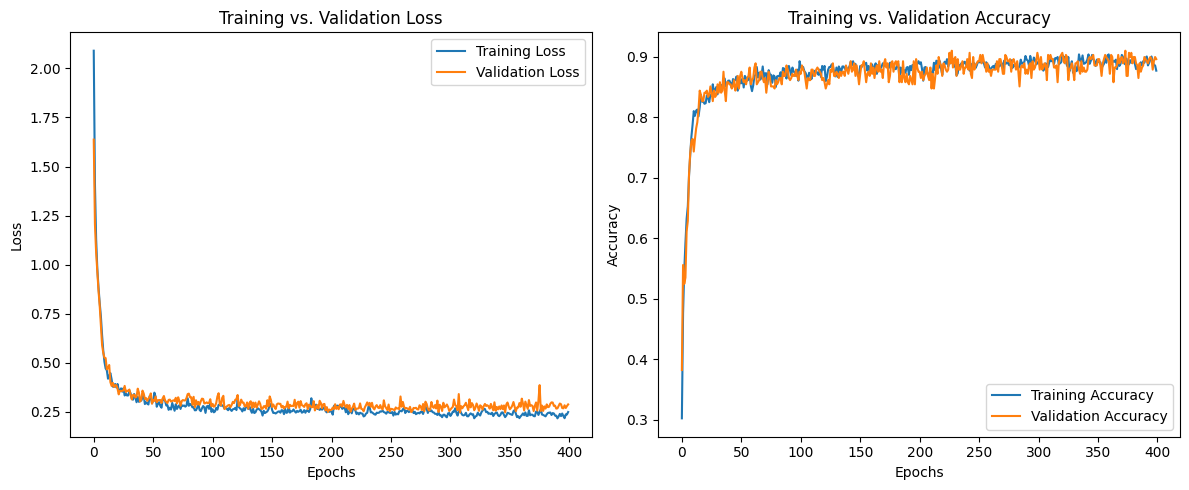

In [ ]:
import matplotlib.pyplot as plt

# Extract training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot Training & Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Predict on test data
y_pred = best_model.predict(X_test)

# Convert one-hot encoded labels back to class indices
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
              precision    recall  f1-score   support

       A_100       0.96      1.00      0.98        25
        A_20       0.70      0.47      0.56        15
        A_40       0.82      0.67      0.74        21
        A_60       0.89      0.92      0.91        26
        A_80       1.00      1.00      1.00        23
       B_100       1.00      1.00      1.00        17
        B_20       1.00      1.00      1.00        18
        B_40       1.00      1.00      1.00        19
        B_60       1.00      1.00      1.00        18
        B_80       1.00      1.00      1.00        18
       C_100       0.58      0.83      0.68        18
        C_20       0.82      0.82      0.82        22
        C_40       0.96      1.00      0.98        24
        C_60       0.82      0.95      0.88        19
        C_80       0.53      0.43      0.47        21
     Healthy       0.95      0.93      0.94        56

    accuracy                           0

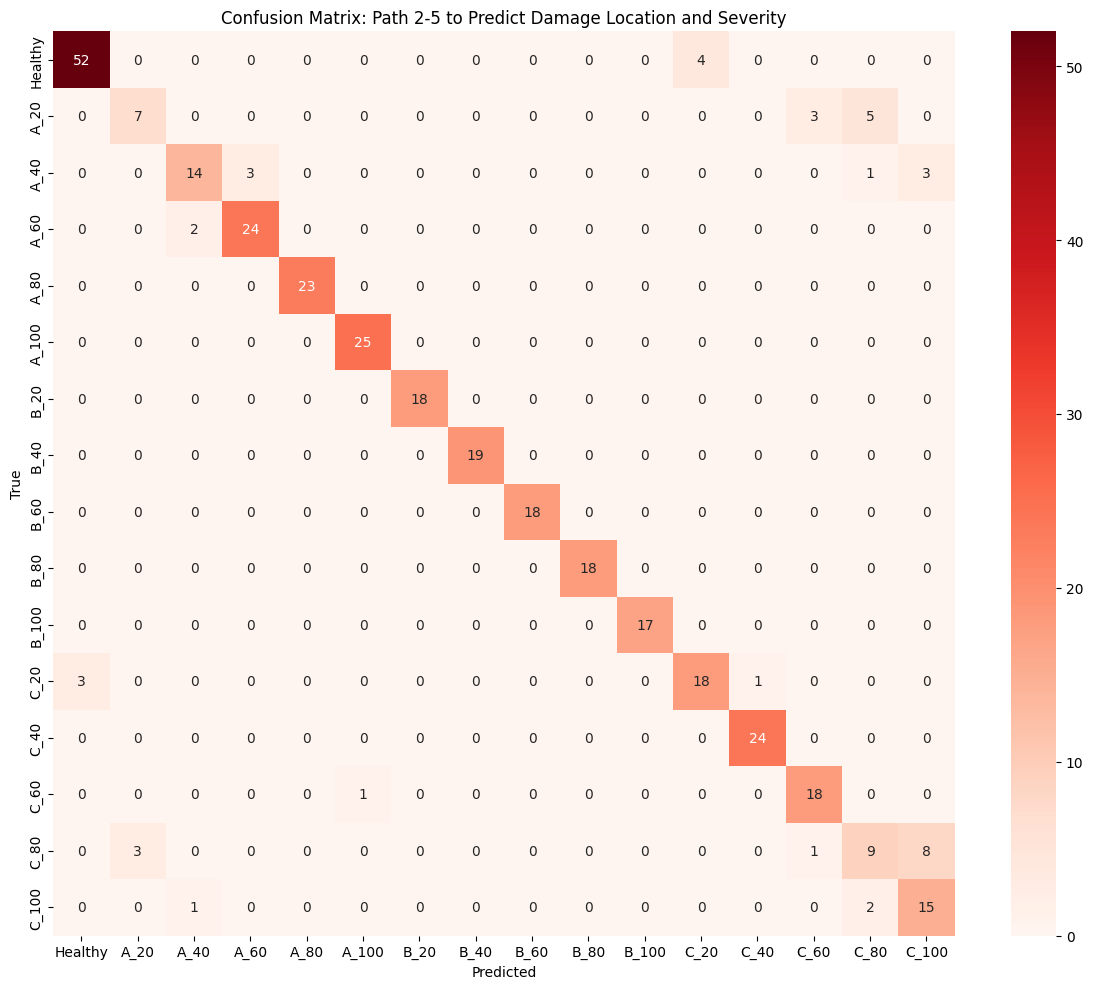

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# Predict
y_pred_probs = best_model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Decode labels
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_true_labels = label_encoder.inverse_transform(y_true)

# Classification Report
print(classification_report(y_true_labels, y_pred_labels))

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=label_encoder.transform(ordered_labels))

# Plot with correct label names
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, xticklabels=ordered_labels, yticklabels=ordered_labels, cmap='Reds')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix: Path 2-5 to Predict Damage Location and Severity")
plt.tight_layout()
plt.show()

# Adding noise to test for robustness



**A.) adding noise to the testing data and seeing how the non-noise trained model performs**



In [ ]:
print("Model expects input shape:", model.input_shape)

Model expects input shape: (None, 3)


In [ ]:
# first, get the time-series version of the input X, split that the same way as before, THEN add the noise
X_train_flat, X_test_flat, y_train, y_test = train_test_split(X_flat, y_categorical, test_size=0.2, random_state=42)
print(X_test_flat.shape)

(360, 334)


In [ ]:
std = np.std(X_test_flat[0])
print(std)

1.0720546


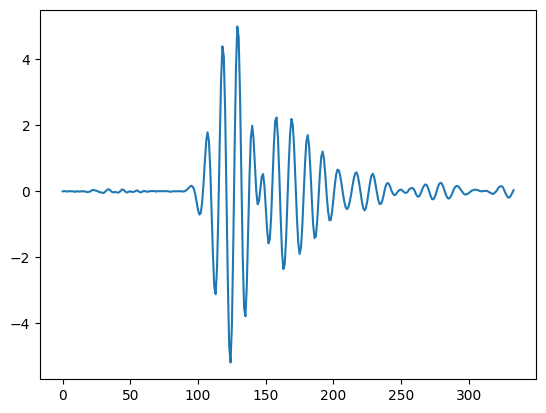

In [ ]:
plt.plot(X_test_flat[0])
plt.show()

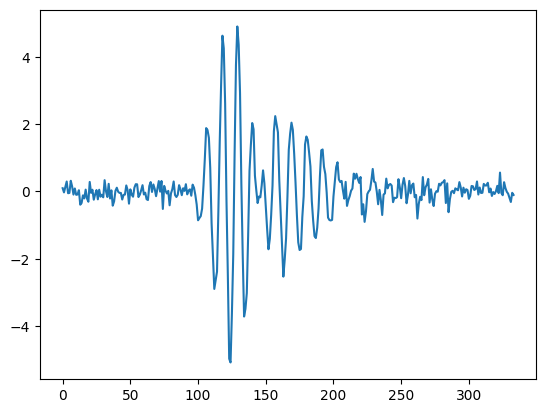

In [ ]:
X_test_noisy = X_test_flat + 0.20 * np.random.normal(loc=0.0, scale=1.0, size=X_test_flat.shape)  # creates a normal distribution for the noise
plt.plot(X_test_noisy[0])
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

noise_levels = [0.0, 0.01, 0.05, 0.1, 0.2] # clean, 1%, 5%, 10%, 20%
noise_accuracies = []
for noise_level in noise_levels:
    # Add noise to the testing data
    print(f"Evaluating Non-noise trained model with noise level: {noise_level}")
    X_test_noisy = X_test_flat + noise_level * np.random.normal(loc=0.0, scale=1.0, size=X_test_flat.shape)  # creates a normal distribution for the noise. Assumes a mean of 0 and std of 1.0

    # get pca of noisy test data
    X_test_noisy_pca = pca.transform(X_test_noisy)

    # predict for this noise level
    y_pred_probs = model.predict(X_test_noisy_pca)
    y_pred = y_pred_probs.argmax(axis=1)
    y_true = y_test.argmax(axis=1)

    # accuracy
    accuracy_noise = accuracy_score(y_true, y_pred)
    noise_accuracies.append(accuracy_noise)
    print(f"Accuracy with noise level {noise_level}: {accuracy_noise}")

Evaluating Non-noise trained model with noise level: 0.0
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy with noise level 0.0: 0.9
Evaluating Non-noise trained model with noise level: 0.01
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy with noise level 0.01: 0.8444444444444444
Evaluating Non-noise trained model with noise level: 0.05
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy with noise level 0.05: 0.6416666666666667
Evaluating Non-noise trained model with noise level: 0.1
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy with noise level 0.1: 0.4666666666666667
Evaluating Non-noise trained model with noise level: 0.2
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy with noise level 0.2: 0.35833333333333334


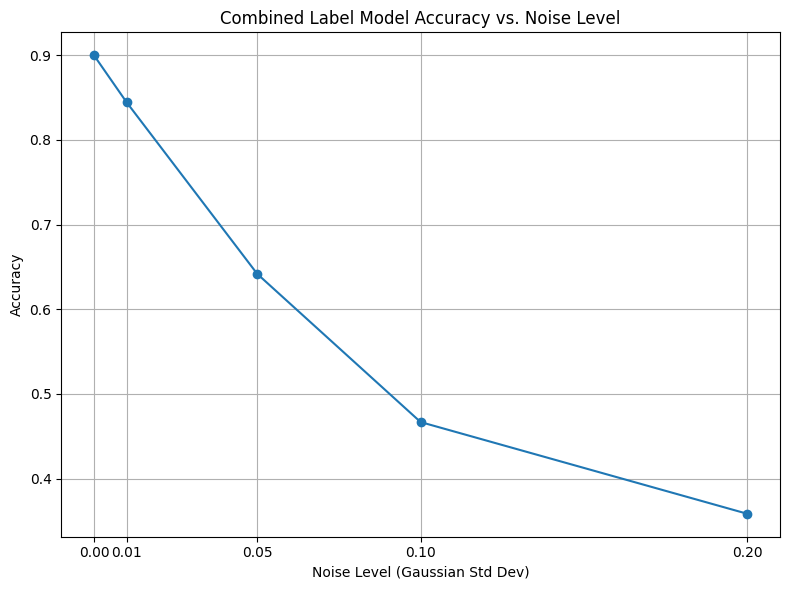

In [ ]:
# Plot
plt.figure(figsize=(8, 6))
plt.plot(noise_levels, noise_accuracies, marker='o')
plt.title("Combined Label Model Accuracy vs. Noise Level")
plt.xticks(noise_levels)
plt.xlabel("Noise Level (Gaussian Std Dev)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

**b.) train on noisy data then test on noisy data - trains for each noise level**

In [ ]:
from sklearn.metrics import accuracy_score

noise_levels = [0.0, 0.01, 0.05, 0.1, 0.2] # clean, 1%, 5%, 10%, 20%
noise_accuracies_trained_on_noise = []
for noise_level in noise_levels:
    # Add noise to the training and testing data
    print(f"Evaluating Non-noise trained model with noise level: {noise_level}")
    X_train_noisy = X_train_flat + noise_level * np.random.normal(loc=0.0, scale=1.0, size=X_train_flat.shape)
    X_test_noisy = X_test_flat + noise_level * np.random.normal(loc=0.0, scale=1.0, size=X_test_flat.shape)  # creates a normal distribution for the noise. Assumes a mean of 0 and std of 1.0

    # get pca of noisy training and test data
    X_train_noisy_pca = pca.transform(X_train_noisy)
    X_test_noisy_pca = pca.transform(X_test_noisy)

    # train model for this noise level
    # Set seed for NumPy, Python, and TensorFlow
    seed_value = 42  # You can pick any fixed number
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

    # Ensure TensorFlow runs in a deterministic manner
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

    model = Sequential([
      Dense(64, activation='relu', input_shape=(X_train_noisy_pca.shape[1],)),
      Dropout(0.3),
      Dense(32, activation='relu'),
      Dense(16, activation='softmax')  # for 16 labels
      ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # train
    history = model.fit(
        X_train_noisy_pca, y_train,
        epochs=200,  # Adjust based on performance
        batch_size=64,  # Common choice, can be tuned
        validation_data=(X_test_noisy_pca, y_test),
        verbose=0
    )

    # predict for this noise level
    y_pred_probs = model.predict(X_test_noisy_pca)
    y_pred = y_pred_probs.argmax(axis=1)
    y_true = y_test.argmax(axis=1)

    # accuracy
    accuracy_noise = accuracy_score(y_true, y_pred)
    noise_accuracies_trained_on_noise.append(accuracy_noise)
    print(f"Accuracy with noise level {noise_level}: {accuracy_noise}")

Evaluating Non-noise trained model with noise level: 0.0


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Accuracy with noise level 0.0: 0.8861111111111111
Evaluating Non-noise trained model with noise level: 0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Accuracy with noise level 0.01: 0.8472222222222222
Evaluating Non-noise trained model with noise level: 0.05


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy with noise level 0.05: 0.5861111111111111
Evaluating Non-noise trained model with noise level: 0.1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Accuracy with noise level 0.1: 0.5111111111111111
Evaluating Non-noise trained model with noise level: 0.2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Accuracy with noise level 0.2: 0.4083333333333333


**model trained on 5% noise level on other noise levels**

In [ ]:
X_train_noise_5 = X_train_flat + 0.05 * np.random.normal(loc=0.0, scale=1.0, size=X_train_flat.shape)

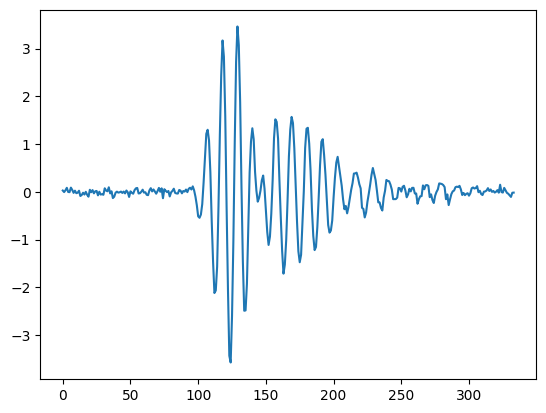

In [ ]:
plt.plot(X_train_noise_5[0])
plt.show()

In [ ]:
X_train_noise_5_pca = pca.transform(X_train_noise_5)

In [ ]:
# train model for 5% noise
seed_value = 42  # You can pick any fixed number
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_noise_5_pca.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(16, activation='softmax')  # for 16 labels
    ])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# train
history = model.fit(
    X_train_noise_5_pca, y_train,
    epochs=200,  # Adjust based on performance
    batch_size=64,  # Common choice, can be tuned
    verbose=0
    )

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
noise_levels = [0.0, 0.01, 0.05, 0.1, 0.2] # clean, 1%, 5%, 10%, 20%
noise_accuracies_trained_on_5_noise = []
for noise_level in noise_levels:
    # Add noise to the training and testing data
    print(f"Evaluating 5% noise trained model with noise level: {noise_level}")
    X_test_noisy = X_test_flat + noise_level * np.random.normal(loc=0.0, scale=1.0, size=X_test_flat.shape)  # creates a normal distribution for the noise. Assumes a mean of 0 and std of 1.0

    # get pca of noisy test data
    X_test_noisy_pca = pca.transform(X_test_noisy)

    # predict for this noise level
    y_pred_probs = model.predict(X_test_noisy_pca)
    y_pred = y_pred_probs.argmax(axis=1)
    y_true = y_test.argmax(axis=1)

    # accuracy
    accuracy_noise = accuracy_score(y_true, y_pred)
    noise_accuracies_trained_on_5_noise.append(accuracy_noise)
    print(f"Accuracy with noise level {noise_level}: {accuracy_noise}")

Evaluating Non-noise trained model with noise level: 0.0
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Accuracy with noise level 0.0: 0.7694444444444445
Evaluating Non-noise trained model with noise level: 0.01
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Accuracy with noise level 0.01: 0.7583333333333333
Evaluating Non-noise trained model with noise level: 0.05
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Accuracy with noise level 0.05: 0.6277777777777778
Evaluating Non-noise trained model with noise level: 0.1
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Accuracy with noise level 0.1: 0.5666666666666667
Evaluating Non-noise trained model with noise level: 0.2
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Accuracy with noise level 0.2: 0.3888888888888889


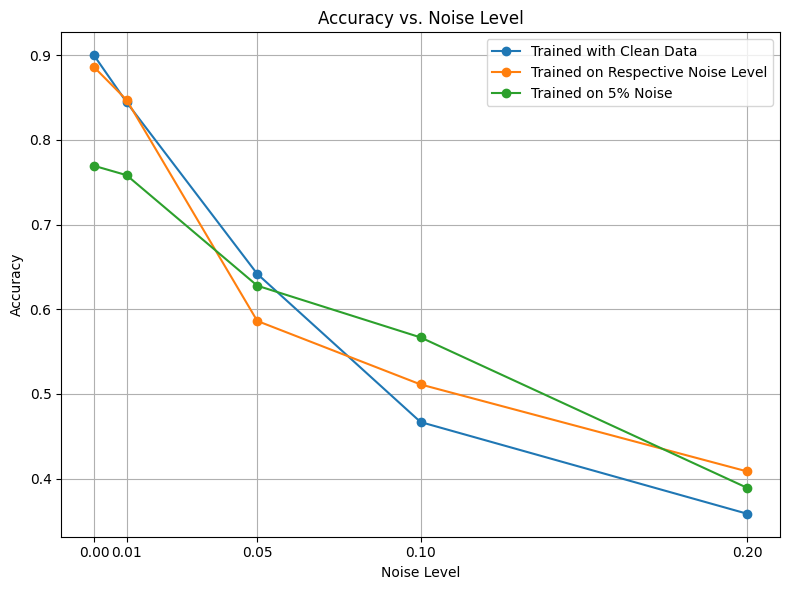

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(noise_levels, noise_accuracies, marker='o')
plt.plot(noise_levels, noise_accuracies_trained_on_noise, marker='o')
plt.plot(noise_levels, noise_accuracies_trained_on_5_noise, marker='o')
plt.xlabel('Noise Level')
plt.xticks(noise_levels)
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Noise Level')
plt.legend(['Trained with Clean Data', 'Trained on Respective Noise Level', 'Trained on 5% Noise'])
plt.grid(True)
plt.tight_layout()
plt.show()

why is the 5% trained model working best on the clean and 0.01 training data, then doing worse on the 10% and 20%? Why isn't 5% noise its best accuracy?

1.) overfitting to the noise

2.) clear signals are inherently easier to identify - 0% and 1% is closer to the true signals/patterns in the signals that the model is learning from. Someone who can read messy handwriting can still read neatwritting, may even have an easier time still reading the neat writting.

3.) regularization/robustness to noise. while not performing as well as the clean model, it shows a greater resistance to noise at 10% and 20% than the clean model.

In [ ]:
# root mean square error of all signals
signals = [x.flatten() for x in X]
df_signals = pd.DataFrame({
    'signal': signals,
    'label': combined_labels
    })
print(df_signals.head)

<bound method NDFrame.head of                                                  signal    label
0     [-0.0051384685, -0.0029555515, 0.0063261166, -...  Healthy
1     [-0.010631892, -0.003051927, -0.0104485955, -0...  Healthy
2     [-0.0069137467, -0.011805426, -0.0027593144, 0...  Healthy
3     [0.006636105, 0.0041285013, 0.0013611868, 0.00...  Healthy
4     [0.0035385182, 0.0031260278, 0.006262913, 0.00...  Healthy
...                                                 ...      ...
1795  [0.002848703, -0.008285404, -0.0036637485, 0.0...     C_20
1796  [0.0038686367, -0.0069596353, -0.014238531, -0...     C_20
1797  [0.0040617567, 0.00063195464, -0.00028731392, ...     C_20
1798  [-0.0054863035, -0.011265091, -0.0050106305, 0...     C_20
1799  [-0.0034026036, -0.02528195, -0.0054345005, 0....     C_20

[1800 rows x 2 columns]>


In [ ]:
# get all healthy signals
healthy_signals = df_signals[df_signals['label'] == 'Healthy']['signal'].to_list()
# Stack and compute mean across axis 0 (i.e., average each time point)
reference_signal = np.mean(np.stack(healthy_signals), axis=0)
print(reference_signal.shape)

(334,)


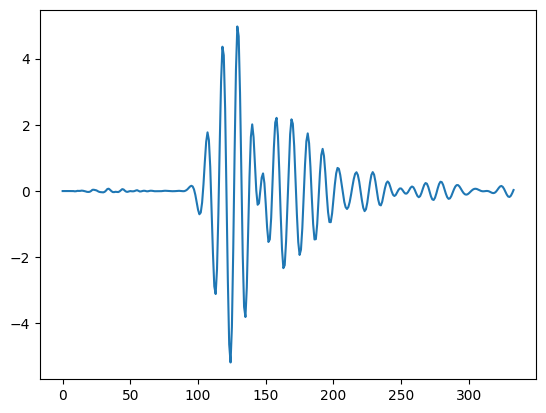

In [ ]:
plt.plot(reference_signal)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
def calculate_RMSE(signal, reference_signal):
    return np.sqrt(mean_squared_error(signal, reference_signal))
df_signals['RMSE'] = df_signals.apply(lambda row: calculate_RMSE(row['signal'], reference_signal), axis=1)

In [ ]:
print(df_signals.head)

<bound method NDFrame.head of                                                  signal    label      RMSE
0     [-0.0051384685, -0.0029555515, 0.0063261166, -...  Healthy  0.006775
1     [-0.010631892, -0.003051927, -0.0104485955, -0...  Healthy  0.006519
2     [-0.0069137467, -0.011805426, -0.0027593144, 0...  Healthy  0.007015
3     [0.006636105, 0.0041285013, 0.0013611868, 0.00...  Healthy  0.006383
4     [0.0035385182, 0.0031260278, 0.006262913, 0.00...  Healthy  0.006141
...                                                 ...      ...       ...
1795  [0.002848703, -0.008285404, -0.0036637485, 0.0...     C_20  0.009071
1796  [0.0038686367, -0.0069596353, -0.014238531, -0...     C_20  0.009957
1797  [0.0040617567, 0.00063195464, -0.00028731392, ...     C_20  0.009012
1798  [-0.0054863035, -0.011265091, -0.0050106305, 0...     C_20  0.009237
1799  [-0.0034026036, -0.02528195, -0.0054345005, 0....     C_20  0.010283

[1800 rows x 3 columns]>


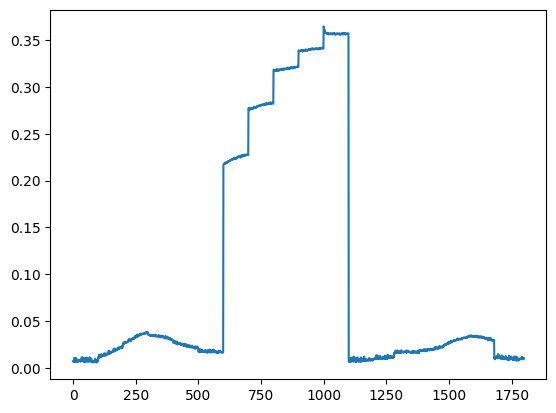

In [ ]:
plt.plot(df_signals['RMSE'])
plt.show()

<ipython-input-42-18e941bf484d>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Display', y='RMSE', data=df_signals, palette='tab20')


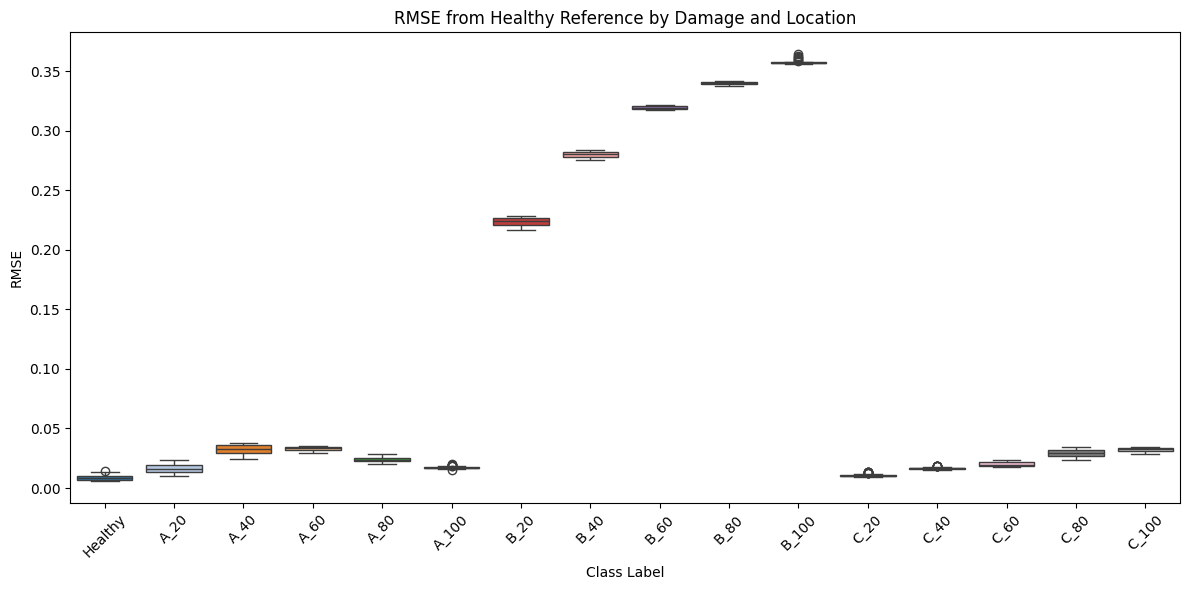

In [ ]:
# plotting
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume df is your existing DataFrame with 'label' and 'RMSE' columns
df_signals['Location'] = df_signals['label'].apply(lambda x: x.split("_")[0] if x != "Healthy" else "Healthy")
df_signals['Damage'] = df_signals['label'].apply(lambda x: x.split("_")[1] if x != "Healthy" else "Healthy")

# Optional: create a combined "Display Label" to keep plotting tidy
df_signals['Display'] = df_signals['label']  # Already structured as you want: Healthy, A_20, B_40, etc.

# Sort by your desired order (optional)
ordered_labels = ['Healthy', 'A_20', 'A_40', 'A_60', 'A_80', 'A_100',
                             'B_20', 'B_40', 'B_60', 'B_80', 'B_100',
                             'C_20', 'C_40', 'C_60', 'C_80', 'C_100']
df_signals['Display'] = pd.Categorical(df_signals['Display'], categories=ordered_labels, ordered=True)

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Display', y='RMSE', data=df_signals, palette='tab20')
plt.xticks(rotation=45)
plt.title('RMSE from Healthy Reference by Damage and Location')
plt.xlabel('Class Label')
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()

In [ ]:
# Expand signal features
df_signals['mean'] = df_signals['signal'].apply(np.mean)
df_signals['std'] = df_signals['signal'].apply(np.std)
df_signals['ptp'] = df_signals['signal'].apply(lambda x: np.ptp(x))  # peak-to-peak

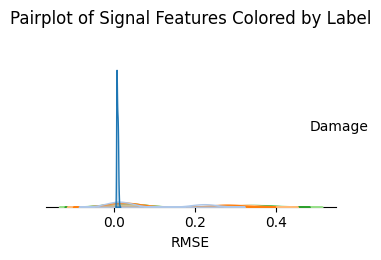

In [ ]:
# Make a clean copy with just the relevant data
df_plot = df_signals.drop(columns=['signal'])  # or df_signals if that's your variable

# Now try pairplot again
sns.pairplot(
    df_plot,
    vars=['RMSE'],
    hue='Damage',  # or 'Location', 'Damage'
    palette='tab20',
    corner=True
)

plt.suptitle('Pairplot of Signal Features Colored by Label', y=1.02)
plt.tight_layout()
plt.show()

**trying pca to CNN**

In [ ]:
# pca to cnn
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import random
import os

# Set seed for NumPy, Python, and TensorFlow
seed_value = 42  # You can pick any fixed number
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Ensure TensorFlow runs in a deterministic manner
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Define the model
model = Sequential([
    Conv1D(32, 2, activation='relu', input_shape=(3, 1)),
    MaxPooling1D(pool_size=1),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(y_combined_cat.shape[1], activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 2, 32)          │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 2, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 2, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 16)             │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,296 (20.69 KB)

 Trainable params: 5,296 (20.69 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=400,  # Adjust based on performance
    batch_size=64,  # Common choice, can be tuned
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.0529 - loss: 2.8463 - val_accuracy: 0.2722 - val_loss: 2.6747
Epoch 2/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.2172 - loss: 2.6230 - val_accuracy: 0.2528 - val_loss: 2.4642
Epoch 3/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2978 - loss: 2.3731 - val_accuracy: 0.2528 - val_loss: 2.2194
Epoch 4/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3109 - loss: 2.1422 - val_accuracy: 0.2833 - val_loss: 2.0425
Epoch 5/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3363 - loss: 1.9821 - val_accuracy: 0.3500 - val_loss: 1.8944
Epoch 6/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3757 - loss: 1.8495 - val_accuracy: 0.4306 - val_loss: 1.7604
Epoch 7/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3890 - loss: 1.7352 - val_accuracy: 0.4167 - val_loss: 1.6338
Epoch 8/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4214 - loss: 1.6323 - val_accuracy: 0.4694 

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8675 - loss: 0.2515 
Test Accuracy: 0.8806


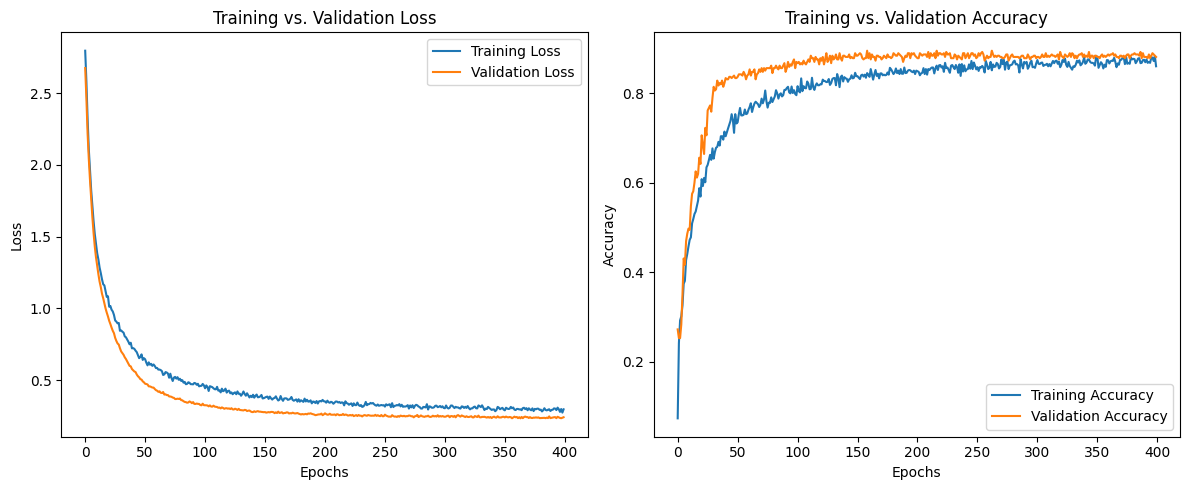

In [ ]:
import matplotlib.pyplot as plt

# Extract training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot Training & Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()